In [25]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from scipy import interpolate as spinter, optimize as spopt
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})

In [26]:
############# SHINY NEW FUNCTIONS ##################

def flatten_list(bookshelf):
    papers= []
    for book in bookshelf:
        if type(book) == str: #strings are iterable but should not be flattened
            papers.append(book)
            continue
        try:
            book[0]
        except: #This is not a list! Add this item to the papers.
            papers.append(book)
        else:
            papers += flatten_list(book) #This is a list! Its items must be seperated first, then it can be added to the papers.
    return papers

def autocrop(array, noise_level= 10, silent= True): #crops to rectangular section with many large values.
    row_s2n = np.std(array, axis= 1) # Try different ways of estimating the S2N
    row_threshold = np.percentile(row_s2n, noise_level)
    column_s2n = np.std(array, axis= 0)
    column_threshold = np.percentile(column_s2n, noise_level)
    first_row, last_row = int(np.argwhere(row_s2n > row_threshold)[0]), int(np.argwhere(row_s2n > row_threshold)[-1])
    first_column, last_column = int(np.argwhere(column_s2n > column_threshold)[0]), int(np.argwhere(column_s2n > column_threshold)[-1])

    if not silent:
        fig, axs = plt.subplots()
        axs.plot(row_s2n, color= "tab:blue")
        axs.plot(column_s2n, color= "tab:orange")
        axs.hlines([row_s2n, column_s2n], colors= ["tab:blue","tab:orange"], xmin= 0, xmax= 1, transform=axs.get_yaxis_transform())
        plt.show()

    return array[first_row:last_row, first_column:last_column]

def dead_pixel_filter(image, dead_pixels =1):
    # Remove the most anomalous 1% of pixels and replace with nearest neighbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(image <= np.percentile(image,upper_percentile), image >= np.percentile(image,lower_percentile) )
    coords = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = spinter.NearestNDInterpolator(coords[notdead], image[notdead])
    image = nearest(coords[:,:,0],coords[:,:,1])

    return image

def filter_files(file_directories, file_names, regex_code):
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]

    return filtered_file_paths, filtered_file_directories, filtered_file_names

def open_pyro_oscilloscope(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    channel = "Ch1" if requested_data == "pyro_time" else requested_data
    regex_code = ".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv"
    filtered_file_paths, _, filtered_file_names = filter_files(file_directories, file_names, regex_code)
                            
    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    pyro_data = [function(np.genfromtxt(filtered_file_path, delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4))
                 for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, pyro_data

def open_emp_oscilloscope(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    emp_oscilloscope = ["time","bdot","tof","diode"]
    column = emp_oscilloscope.index(requested_data)
    regex_code = "(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv"
    filtered_file_paths, _, filtered_file_names = filter_files(file_directories, file_names, regex_code)

    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    emp_data = [function(np.genfromtxt(filtered_file_path, delimiter=',', skip_header =18, usecols= column))
                for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, emp_data

def open_xray_photos(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    raw = "-raw" if requested_data == "xray_raw" else ""
    regex_code = ".*[0-9]{2}" +raw+ " SHOT(" +'|'.join(shots)+ ").tif"
    filtered_file_paths, _, filtered_file_names = filter_files(file_directories, file_names, regex_code)

    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    data = [function(np.array(Image.open(filtered_file_path))) for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, data


def read_diagnostic_data(requested_data, function= lambda x:x , silent= False): #Currently supports the xray cam, pyro oscilloscope and the emp oscilloscope. Doesn't support target photos, espec, focal spot cam and pyrocams. 
    data_path = "organised_data\\"
    dictionary = {"shot":[]}
    emp_oscilloscope = ["time","bdot","tof","diode"]
    pyro_oscilloscope = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]
    xray_cam = ["xray", "xray_raw"]

    all_file_directories = [root for root, dirs, files in os.walk(data_path) for file in files]
    all_file_directories = np.array(all_file_directories)
    all_file_names = [file for root, dirs, files in os.walk(data_path) for file in files]
    all_file_names = np.array(all_file_names)
    requested_data = {ch: [str(int(shot)) for shot in shots] for ch, shots in requested_data.items()} # ensure that all shot numbers are strings of ints. floats will screw up regex.

    for request, shots in requested_data.items():
        if request in pyro_oscilloscope:
            new_shots, new_data = open_pyro_oscilloscope(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        elif request in emp_oscilloscope:
            new_shots, new_data = open_emp_oscilloscope(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        elif request in xray_cam:
            new_shots, new_data = open_xray_photos(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        else:
            new_shots, new_data = [], []
            print("WARNING!! {0} is not a recognised data type.".format(request))

        old_shots = dictionary["shot"]
        union_shots = np.unique(old_shots + new_shots).tolist()

        dictionary = {diagnostic: [readings[old_shots.index(shot)] if shot in old_shots else np.nan for shot in union_shots] for diagnostic, readings in dictionary.items()} #rearrange the existing data to corrispond with its respective shot
        dictionary[request] = [new_data[new_shots.index(shot)] if shot in new_shots else np.nan for shot in union_shots] # Add the new data to it's respective shot.
        dictionary["shot"] = union_shots #add the new shots

    return dictionary

In [29]:
xray = {"xray": [4,25,45,65,75,85,115]}

photos = read_diagnostic_data(xray)

example_photo = photos["xray"][2]
example_filtered = dead_pixel_filter(example_photo, dead_pixels=1)
example_cropped = autocrop(example_filtered, noise_level= 96)

Found 3 files:
   2024 janvier 26 16_28_44 SHOT75.tif
   2024 janvier 29 17_45_50 SHOT85.tif
   2024 janvier 30 16_48_18 SHOT115.tif


C:\Users\syf83691\AppData\Local\Temp\ipykernel_2376\1589394494.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  first_row, last_row = int(np.argwhere(row_s2n > row_threshold)[0]), int(np.argwhere(row_s2n > row_threshold)[-1])
C:\Users\syf83691\AppData\Local\Temp\ipykernel_2376\1589394494.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  first_column, last_column = int(np.argwhere(column_s2n > column_threshold)[0]), int(np.argwhere(column_s2n > column_threshold)[-1])


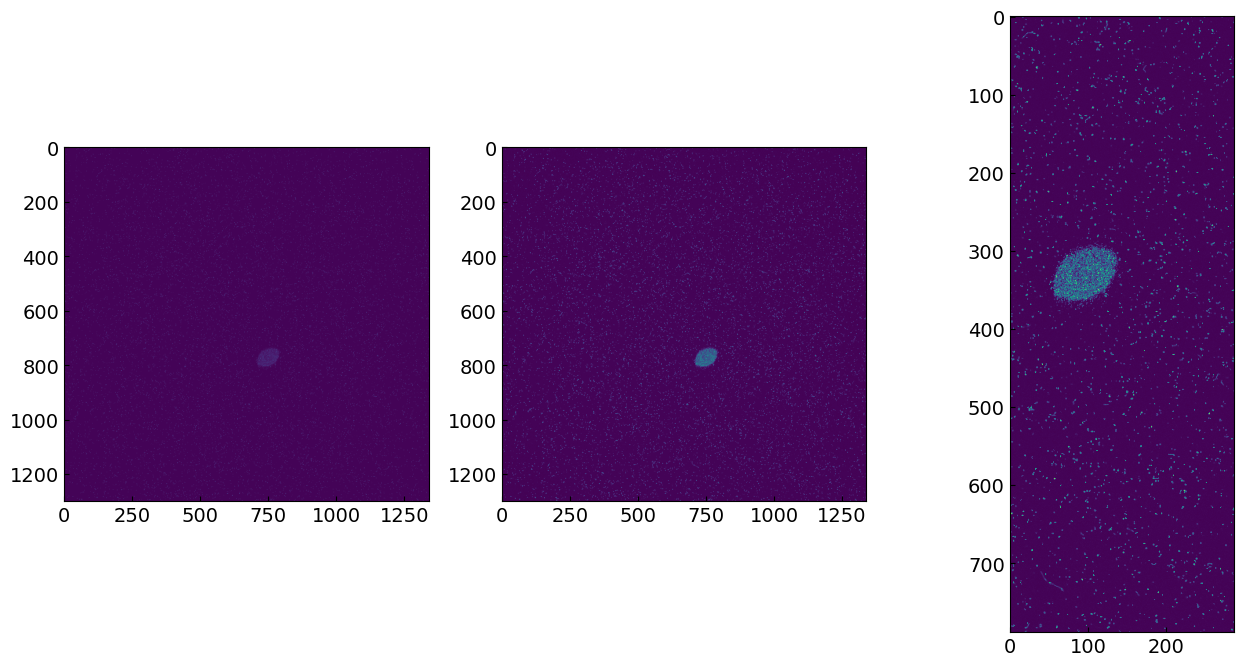

In [30]:
fig, axs = plt.subplots(1,3, figsize= (16,8))
axs = flatten_list(axs)

axs[0].imshow(example_photo)
axs[1].imshow(example_filtered)
axs[2].imshow(example_cropped)


plt.show()